In [39]:
from scipy import stats
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt

In [32]:
current_dir = os.getcwd()
# Navigate up to the project root (from notebooks folder to project root)
project_root = os.path.dirname(current_dir)
csv_file = os.path.join(project_root, "output_data", "icp_supply_data_2023-10-01_to_2025-10-03_20251003_211226.csv")
df = pd.read_csv(csv_file)

In [33]:
df_adj = df.dropna(subset=['supply_change', 'supply_change_pct']).copy()
df_adj['total_supply'] = df_adj['total_supply'] / 100_000_000
df_adj['supply_change'] = df_adj['supply_change'] / 100_000_000
print(df_adj.shape)
df_adj.tail()

(733, 6)


,timestamp,date,total_supply,datetime,supply_change,supply_change_pct
729,1759104000,2025-09-28,5.382099e+08,2025-09-29 00:00:00,3391.890852,0.000630
730,1759190400,2025-09-29,5.383049e+08,2025-09-30 00:00:00,95075.865930,0.017665
731,1759276800,2025-09-30,5.383969e+08,2025-10-01 00:00:00,92006.346594,0.017092
732,1759363200,2025-10-01,5.384089e+08,2025-10-02 00:00:00,11917.767445,0.002214
733,1759449600,2025-10-02,5.384458e+08,2025-10-03 00:00:00,36918.177163,0.006857


In [34]:
df_adj['change_7d_avg'] = df_adj['supply_change'].rolling(window=7).mean()
df_adj['change_30d_avg'] = df_adj['supply_change'].rolling(window=30).mean()
df_adj.tail()

,timestamp,date,total_supply,datetime,supply_change,supply_change_pct,change_7d_avg,change_30d_avg
729,1759104000,2025-09-28,5.382099e+08,2025-09-29 00:00:00,3391.890852,0.000630,14927.463593,26233.305356
730,1759190400,2025-09-29,5.383049e+08,2025-09-30 00:00:00,95075.865930,0.017665,26448.531569,29239.348379
731,1759276800,2025-09-30,5.383969e+08,2025-10-01 00:00:00,92006.346594,0.017092,37840.189821,32351.335240
732,1759363200,2025-10-01,5.384089e+08,2025-10-02 00:00:00,11917.767445,0.002214,36376.247407,32537.556986
733,1759449600,2025-10-02,5.384458e+08,2025-10-03 00:00:00,36918.177163,0.006857,39908.441559,33501.543177


Overall slope: -3.27e-04
R-squared: 0.0035
P-value: 1.08e-01


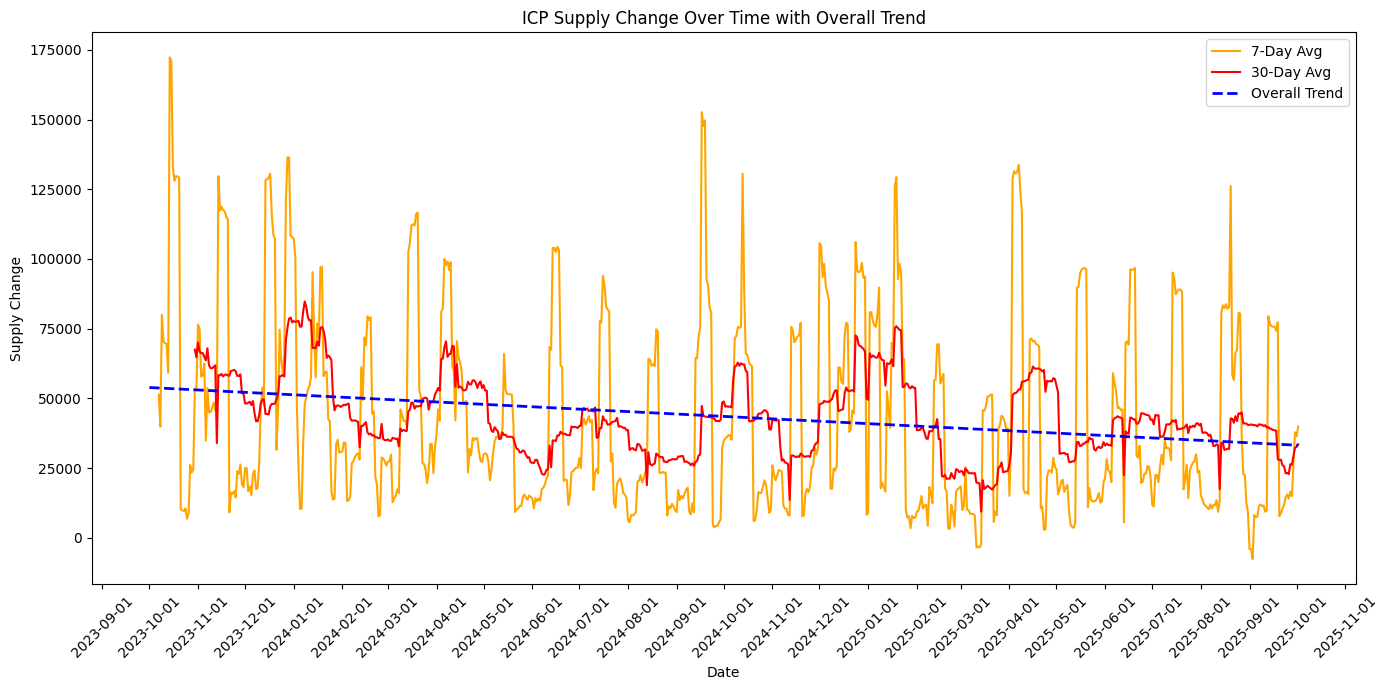

In [42]:
# Convert dates to numerical values for regression
df_adj['date_dt'] = pd.to_datetime(df_adj['date'])
df_adj['date_numeric'] = df_adj['date_dt'].map(pd.Timestamp.timestamp)

# Remove NaN values for slope calculation
valid_data = df_adj.dropna(subset=['supply_change', 'date_numeric'])

# Calculate linear regression (slope)
slope, intercept, r_value, p_value, std_err = stats.linregress(valid_data['date_numeric'], valid_data['supply_change'])

# Create trend line data
trend_line = slope * valid_data['date_numeric'] + intercept

print(f"Overall slope: {slope:.2e}")
print(f"R-squared: {r_value**2:.4f}")
print(f"P-value: {p_value:.2e}")

# Create the chart with trend line
plt.figure(figsize=(14, 7))
plt.plot(df_adj['date_dt'], df_adj['change_7d_avg'], label='7-Day Avg', color='orange')
plt.plot(df_adj['date_dt'], df_adj['change_30d_avg'], label='30-Day Avg', color='red')
plt.plot(valid_data['date_dt'], trend_line, label='Overall Trend', color='blue', linestyle='--', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Supply Change')
plt.title('ICP Supply Change Over Time with Overall Trend')
plt.legend()

# Set x-axis ticks to show only 1st day of each month
from matplotlib.dates import DateFormatter, MonthLocator
import matplotlib.dates as mdates

# Set major ticks to first day of each month
ax = plt.gca()
ax.xaxis.set_major_locator(MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [49]:
# Create the same chart using Plotly for interactivity
import plotly.graph_objects as go

# Create the plotly figure
fig = go.Figure()

# Add 7-day average line
fig.add_trace(go.Scatter(
    x=df_adj['date_dt'], 
    y=df_adj['change_7d_avg'],
    mode='lines',
    name='7-Day Avg',
    line=dict(color='orange', width=2),
    hovertemplate='<b>7-Day Avg</b><br>Date: %{x}<br>Supply Change: %{y:.0f}<extra></extra>'
))

# Add 30-day average line
fig.add_trace(go.Scatter(
    x=df_adj['date_dt'], 
    y=df_adj['change_30d_avg'],
    mode='lines',
    name='30-Day Avg',
    line=dict(color='red', width=2),
    hovertemplate='<b>30-Day Avg</b><br>Date: %{x}<br>Supply Change: %{y:.0f}<extra></extra>'
))

# Add trend line
fig.add_trace(go.Scatter(
    x=valid_data['date_dt'], 
    y=trend_line,
    mode='lines',
    name='Overall Trend',
    line=dict(color='blue', width=2, dash='dash'),
    hovertemplate='<b>Overall Trend</b><br>Date: %{x}<br>Supply Change: %{y:.0f}<extra></extra>'
))

# Update layout
fig.update_layout(
    title='ICP Supply Change Over Time with Overall Trend (Interactive)',
    xaxis_title='Date',
    yaxis_title='Supply Change',
    width=1000,
    height=500,
    hovermode='x unified',
    template='plotly_white'
)

# Set x-axis to show only 1st day of each month
fig.update_xaxes(
    dtick="M1",  # Monthly ticks
    tickformat="%Y-%m-%d",
    tickangle=45
)

# Add annotation with slope information
fig.add_annotation(
    x=0.02, y=0.98,
    xref='paper', yref='paper',
    text=f"Overall slope: {slope:.2e}",
    showarrow=False,
    bgcolor="rgba(255,255,255,0.8)",
    bordercolor="black",
    borderwidth=1,
    font=dict(size=10)
)

# Print statistics and try to display
print("Plotly chart created successfully!")
print(f"Chart contains {len(fig.data)} traces")
print("Note: Interactive chart should display above this text")

# Try different display methods
try:
    fig.show()
except Exception as e:
    print(f"Standard show() failed: {e}")
    # Alternative: save as HTML and show path
    html_file = "icp_supply_chart.html"
    fig.write_html(html_file)
    print(f"Chart saved to {html_file} - you can open this file in a browser to view the interactive chart")

Plotly chart created successfully!
Chart contains 3 traces
Note: Interactive chart should display above this text
Standard show() failed: Mime type rendering requires nbformat>=4.2.0 but it is not installed
Chart saved to icp_supply_chart.html - you can open this file in a browser to view the interactive chart


In [51]:
# Calculate quarterly slopes from daily data
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from datetime import datetime
import calendar

# Group data by year-quarter for quarterly slope calculation
df_adj['year_quarter'] = df_adj['date_dt'].dt.to_period('Q')
quarterly_slopes = []
quarterly_periods = []
quarterly_trend_lines = {}

print("Calculating quarterly slopes...")

for period in df_adj['year_quarter'].unique():
    if pd.isna(period):
        continue
    
    # Get data for this quarter
    quarter_data = df_adj[df_adj['year_quarter'] == period].copy()
    
    # Skip if insufficient data points
    if len(quarter_data) < 10:
        continue
    
    # Remove NaN values
    quarter_valid = quarter_data.dropna(subset=['supply_change', 'date_numeric'])
    
    if len(quarter_valid) < 10:
        continue
    
    # Calculate slope for this quarter
    slope_quarter, intercept_quarter, r_value_quarter, p_value_quarter, std_err_quarter = stats.linregress(
        quarter_valid['date_numeric'], quarter_valid['supply_change']
    )
    
    # Create trend line for this quarter
    trend_line_quarter = slope_quarter * quarter_valid['date_numeric'] + intercept_quarter
    
    quarterly_slopes.append(slope_quarter)
    quarterly_periods.append(period)
    quarterly_trend_lines[period] = {
        'x': quarter_valid['date_dt'],
        'y': trend_line_quarter,
        'slope': slope_quarter,
        'r_squared': r_value_quarter**2
    }
    
    print(f"{period}: slope = {slope_quarter:.2e}, R² = {r_value_quarter**2:.4f}")

print(f"\nCalculated slopes for {len(quarterly_slopes)} quarters")

# Create updated plotly chart with quarterly slopes instead of overall trend
fig = go.Figure()

# Add 7-day average line
fig.add_trace(go.Scatter(
    x=df_adj['date_dt'], 
    y=df_adj['change_7d_avg'],
    mode='lines',
    name='7-Day Avg',
    line=dict(color='orange', width=2),
    hovertemplate='<b>7-Day Avg</b><br>Date: %{x}<br>Supply Change: %{y:.0f}<extra></extra>'
))

# Add 30-day average line (changed to blue)
fig.add_trace(go.Scatter(
    x=df_adj['date_dt'], 
    y=df_adj['change_30d_avg'],
    mode='lines',
    name='30-Day Avg',
    line=dict(color='blue', width=2),
    hovertemplate='<b>30-Day Avg</b><br>Date: %{x}<br>Supply Change: %{y:.0f}<extra></extra>'
))

# Add quarterly trend lines with color based on slope direction
for i, (period, trend_data) in enumerate(quarterly_trend_lines.items()):
    # Set color based on slope: red for positive, green for negative
    slope_color = 'red' if trend_data['slope'] > 0 else 'green'
    
    fig.add_trace(go.Scatter(
        x=trend_data['x'], 
        y=trend_data['y'],
        mode='lines',
        name=f'{period} Trend',
        line=dict(color=slope_color, width=2),  # Regular lines, not dashed
        hovertemplate=f'<b>{period} Trend</b><br>Date: %{{x}}<br>Supply Change: %{{y:.0f}}<br>Slope: {trend_data["slope"]:.2e}<extra></extra>'
    ))

# Update layout
fig.update_layout(
    title='ICP Supply Change Over Time with Quarterly Trend Lines (Interactive)',
    xaxis_title='Date',
    yaxis_title='Supply Change',
    width=1000,
    height=600,
    hovermode='x unified',
    template='plotly_white'
)

# Set x-axis to show only 1st day of each month
fig.update_xaxes(
    dtick="M1",  # Monthly ticks
    tickformat="%Y-%m-%d",
    tickangle=45
)

# Add annotation with quarterly slope statistics
slope_stats = f"Quarterly slopes: min={min(quarterly_slopes):.2e}, max={max(quarterly_slopes):.2e}, avg={np.mean(quarterly_slopes):.2e}"
fig.add_annotation(
    x=0.02, y=0.98,
    xref='paper', yref='paper',
    text=slope_stats,
    showarrow=False,
    bgcolor="rgba(255,255,255,0.8)",
    bordercolor="black",
    borderwidth=1,
    font=dict(size=10)
)

# Print statistics and display
print("\nUpdated chart with quarterly trends created successfully!")
print(f"Chart contains {len(fig.data)} traces")
print("Note: Interactive chart should display above this text")

# Display the chart
try:
    fig.show()
except Exception as e:
    print(f"Standard show() failed: {e}")
    # Alternative: save as HTML and show path
    html_file = "icp_supply_chart_quarterly_trends.html"
    fig.write_html(html_file)
    print(f"Chart saved to {html_file} - you can open this file in a browser to view the interactive chart")

Calculating quarterly slopes...
2023Q4: slope = 1.65e-03, R² = 0.0007
2024Q1: slope = 3.88e-04, R² = 0.0001
2024Q2: slope = -4.19e-03, R² = 0.0191
2024Q3: slope = 9.83e-04, R² = 0.0006
2024Q4: slope = 2.88e-03, R² = 0.0036
2025Q1: slope = -6.29e-03, R² = 0.0241
2025Q2: slope = -5.14e-03, R² = 0.0099
2025Q3: slope = -1.30e-03, R² = 0.0010

Calculated slopes for 8 quarters

Updated chart with quarterly trends created successfully!
Chart contains 10 traces
Note: Interactive chart should display above this text
Standard show() failed: Mime type rendering requires nbformat>=4.2.0 but it is not installed
Chart saved to icp_supply_chart_quarterly_trends.html - you can open this file in a browser to view the interactive chart
Chart saved to icp_supply_chart_quarterly_trends.html - you can open this file in a browser to view the interactive chart


In [52]:
# Create interactive multi-trend chart with dropdown selector
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def calculate_all_trends():
    """Calculate trends for different time periods"""
    
    # Monthly trends (already calculated previously)
    df_adj['year_month'] = df_adj['date_dt'].dt.to_period('M')
    monthly_trends = {}
    
    for period in df_adj['year_month'].unique():
        if pd.isna(period):
            continue
        
        month_data = df_adj[df_adj['year_month'] == period].copy()
        if len(month_data) < 3:
            continue
        
        month_valid = month_data.dropna(subset=['supply_change', 'date_numeric'])
        if len(month_valid) < 3:
            continue
        
        slope_m, intercept_m, r_value_m, p_value_m, std_err_m = stats.linregress(
            month_valid['date_numeric'], month_valid['supply_change']
        )
        
        trend_line_m = slope_m * month_valid['date_numeric'] + intercept_m
        
        monthly_trends[period] = {
            'x': month_valid['date_dt'],
            'y': trend_line_m,
            'slope': slope_m,
            'r_squared': r_value_m**2
        }
    
    # Quarterly trends (already calculated)
    quarterly_trends = quarterly_trend_lines
    
    # Yearly trends
    df_adj['year'] = df_adj['date_dt'].dt.to_period('Y')
    yearly_trends = {}
    
    for period in df_adj['year'].unique():
        if pd.isna(period):
            continue
        
        year_data = df_adj[df_adj['year'] == period].copy()
        if len(year_data) < 30:
            continue
        
        year_valid = year_data.dropna(subset=['supply_change', 'date_numeric'])
        if len(year_valid) < 30:
            continue
        
        slope_y, intercept_y, r_value_y, p_value_y, std_err_y = stats.linregress(
            year_valid['date_numeric'], year_valid['supply_change']
        )
        
        trend_line_y = slope_y * year_valid['date_numeric'] + intercept_y
        
        yearly_trends[period] = {
            'x': year_valid['date_dt'],
            'y': trend_line_y,
            'slope': slope_y,
            'r_squared': r_value_y**2
        }
    
    # Full dataset trend (already calculated as overall trend)
    full_trend = {
        'overall': {
            'x': valid_data['date_dt'],
            'y': trend_line,
            'slope': slope,
            'r_squared': r_value**2
        }
    }
    
    return monthly_trends, quarterly_trends, yearly_trends, full_trend

# Calculate all trend types
monthly_trends, quarterly_trends, yearly_trends, full_trend = calculate_all_trends()

# Create the main figure
fig = go.Figure()

# Add base traces (7-day and 30-day averages) - these are always visible
fig.add_trace(go.Scatter(
    x=df_adj['date_dt'], 
    y=df_adj['change_7d_avg'],
    mode='lines',
    name='7-Day Avg',
    line=dict(color='orange', width=2),
    hovertemplate='<b>7-Day Avg</b><br>Date: %{x}<br>Supply Change: %{y:.0f}<extra></extra>'
))

fig.add_trace(go.Scatter(
    x=df_adj['date_dt'], 
    y=df_adj['change_30d_avg'],
    mode='lines',
    name='30-Day Avg',
    line=dict(color='blue', width=2),
    hovertemplate='<b>30-Day Avg</b><br>Date: %{x}<br>Supply Change: %{y:.0f}<extra></extra>'
))

# Add trend traces (initially hidden except for quarterly)
trace_count = 2  # Start after the two base traces

# Add monthly trend lines
monthly_traces = []
for i, (period, trend_data) in enumerate(monthly_trends.items()):
    slope_color = 'red' if trend_data['slope'] > 0 else 'green'
    
    fig.add_trace(go.Scatter(
        x=trend_data['x'], 
        y=trend_data['y'],
        mode='lines',
        name=f'{period} Trend',
        line=dict(color=slope_color, width=2),
        visible=False,  # Initially hidden
        hovertemplate=f'<b>{period} Trend</b><br>Date: %{{x}}<br>Supply Change: %{{y:.0f}}<br>Slope: {trend_data["slope"]:.2e}<extra></extra>'
    ))
    monthly_traces.append(trace_count)
    trace_count += 1

# Add quarterly trend lines
quarterly_traces = []
for i, (period, trend_data) in enumerate(quarterly_trends.items()):
    slope_color = 'red' if trend_data['slope'] > 0 else 'green'
    
    fig.add_trace(go.Scatter(
        x=trend_data['x'], 
        y=trend_data['y'],
        mode='lines',
        name=f'{period} Trend',
        line=dict(color=slope_color, width=2),
        visible=True,  # Initially visible (default)
        hovertemplate=f'<b>{period} Trend</b><br>Date: %{{x}}<br>Supply Change: %{{y:.0f}}<br>Slope: {trend_data["slope"]:.2e}<extra></extra>'
    ))
    quarterly_traces.append(trace_count)
    trace_count += 1

# Add yearly trend lines
yearly_traces = []
for i, (period, trend_data) in enumerate(yearly_trends.items()):
    slope_color = 'red' if trend_data['slope'] > 0 else 'green'
    
    fig.add_trace(go.Scatter(
        x=trend_data['x'], 
        y=trend_data['y'],
        mode='lines',
        name=f'{period} Trend',
        line=dict(color=slope_color, width=2),
        visible=False,  # Initially hidden
        hovertemplate=f'<b>{period} Trend</b><br>Date: %{{x}}<br>Supply Change: %{{y:.0f}}<br>Slope: {trend_data["slope"]:.2e}<extra></extra>'
    ))
    yearly_traces.append(trace_count)
    trace_count += 1

# Add full trend line
full_traces = []
for period, trend_data in full_trend.items():
    fig.add_trace(go.Scatter(
        x=trend_data['x'], 
        y=trend_data['y'],
        mode='lines',
        name='Overall Trend',
        line=dict(color='purple', width=3),
        visible=False,  # Initially hidden
        hovertemplate=f'<b>Overall Trend</b><br>Date: %{{x}}<br>Supply Change: %{{y:.0f}}<br>Slope: {trend_data["slope"]:.2e}<extra></extra>'
    ))
    full_traces.append(trace_count)
    trace_count += 1

# Create visibility arrays for dropdown
def create_visibility_array(total_traces, base_traces, trend_traces):
    """Create visibility array for dropdown options"""
    visibility = [False] * total_traces
    # Always show base traces (7-day and 30-day averages)
    visibility[0] = True  # 7-day avg
    visibility[1] = True  # 30-day avg
    # Show selected trend traces
    for trace_idx in trend_traces:
        visibility[trace_idx] = True
    return visibility

total_traces = len(fig.data)
base_traces = [0, 1]  # 7-day and 30-day averages

# Create dropdown menu
fig.update_layout(
    updatemenus=[
        dict(
            buttons=list([
                dict(
                    args=[{"visible": create_visibility_array(total_traces, base_traces, monthly_traces)}],
                    label="Monthly Trends",
                    method="restyle"
                ),
                dict(
                    args=[{"visible": create_visibility_array(total_traces, base_traces, quarterly_traces)}],
                    label="Quarterly Trends",
                    method="restyle"
                ),
                dict(
                    args=[{"visible": create_visibility_array(total_traces, base_traces, yearly_traces)}],
                    label="Yearly Trends",
                    method="restyle"
                ),
                dict(
                    args=[{"visible": create_visibility_array(total_traces, base_traces, full_traces)}],
                    label="Full Trend",
                    method="restyle"
                )
            ]),
            direction="down",
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.1,
            xanchor="left",
            y=1.15,
            yanchor="top"
        ),
    ]
)

# Update layout
fig.update_layout(
    title='ICP Supply Change Over Time - Interactive Trend Analysis',
    xaxis_title='Date',
    yaxis_title='Supply Change',
    width=1200,
    height=700,
    hovermode='x unified',
    template='plotly_white'
)

# Set x-axis to show monthly ticks
fig.update_xaxes(
    dtick="M1",
    tickformat="%Y-%m-%d",
    tickangle=45
)

# Add instructions annotation
fig.add_annotation(
    x=0.02, y=0.98,
    xref='paper', yref='paper',
    text="Use dropdown menu above to switch between trend periods<br>Red = Positive slopes, Green = Negative slopes",
    showarrow=False,
    bgcolor="rgba(255,255,255,0.9)",
    bordercolor="black",
    borderwidth=1,
    font=dict(size=10)
)

print("Interactive multi-trend chart created successfully!")
print("Features:")
print("- Dropdown menu to switch between Monthly, Quarterly, Yearly, and Full trends")
print("- Color coding: Red for positive slopes, Green for negative slopes") 
print("- Always shows 7-day (orange) and 30-day (blue) averages")
print(f"- Monthly trends: {len(monthly_trends)} periods")
print(f"- Quarterly trends: {len(quarterly_trends)} periods") 
print(f"- Yearly trends: {len(yearly_trends)} periods")
print("- Full trend: Overall dataset trend")

# Display the chart
try:
    fig.show()
except Exception as e:
    print(f"Standard show() failed: {e}")
    html_file = "icp_supply_interactive_trends.html"
    fig.write_html(html_file)
    print(f"Chart saved to {html_file} - you can open this file in a browser to view the interactive chart")

Interactive multi-trend chart created successfully!
Features:
- Dropdown menu to switch between Monthly, Quarterly, Yearly, and Full trends
- Color coding: Red for positive slopes, Green for negative slopes
- Always shows 7-day (orange) and 30-day (blue) averages
- Monthly trends: 24 periods
- Quarterly trends: 8 periods
- Yearly trends: 3 periods
- Full trend: Overall dataset trend
Standard show() failed: Mime type rendering requires nbformat>=4.2.0 but it is not installed
Chart saved to icp_supply_interactive_trends.html - you can open this file in a browser to view the interactive chart


In [53]:
# Calculate and chart the speed of change of supply (1st derivative)
import numpy as np
import plotly.graph_objects as go

# Calculate first derivative (speed of change) of supply change
# Using numpy's gradient function for numerical differentiation
df_adj_sorted = df_adj.sort_values('date_dt').copy()

# Calculate derivatives for different metrics
df_adj_sorted['supply_change_derivative'] = np.gradient(df_adj_sorted['supply_change'])
df_adj_sorted['change_7d_avg_derivative'] = np.gradient(df_adj_sorted['change_7d_avg'].fillna(0))
df_adj_sorted['change_30d_avg_derivative'] = np.gradient(df_adj_sorted['change_30d_avg'].fillna(0))

# Alternative method: calculate discrete differences (day-to-day change in supply change rate)
df_adj_sorted['supply_change_diff'] = df_adj_sorted['supply_change'].diff()
df_adj_sorted['change_7d_avg_diff'] = df_adj_sorted['change_7d_avg'].diff()
df_adj_sorted['change_30d_avg_diff'] = df_adj_sorted['change_30d_avg'].diff()

# Calculate rolling averages of the derivatives to smooth the data
df_adj_sorted['derivative_7d_avg'] = df_adj_sorted['supply_change_derivative'].rolling(window=7).mean()
df_adj_sorted['derivative_30d_avg'] = df_adj_sorted['supply_change_derivative'].rolling(window=30).mean()

print("Calculated speed of change (1st derivative) metrics:")
print(f"Raw derivative range: {df_adj_sorted['supply_change_derivative'].min():.2e} to {df_adj_sorted['supply_change_derivative'].max():.2e}")
print(f"7-day avg derivative range: {df_adj_sorted['derivative_7d_avg'].min():.2e} to {df_adj_sorted['derivative_7d_avg'].max():.2e}")
print(f"30-day avg derivative range: {df_adj_sorted['derivative_30d_avg'].min():.2e} to {df_adj_sorted['derivative_30d_avg'].max():.2e}")

# Create interactive chart for speed of change
fig_derivative = go.Figure()

# Add raw daily derivative (speed of change)
fig_derivative.add_trace(go.Scatter(
    x=df_adj_sorted['date_dt'], 
    y=df_adj_sorted['supply_change_derivative'],
    mode='lines',
    name='Daily Speed of Change',
    line=dict(color='lightgray', width=1),
    opacity=0.5,
    hovertemplate='<b>Daily Speed of Change</b><br>Date: %{x}<br>Speed: %{y:.2e}<extra></extra>'
))

# Add 7-day average of derivative
fig_derivative.add_trace(go.Scatter(
    x=df_adj_sorted['date_dt'], 
    y=df_adj_sorted['derivative_7d_avg'],
    mode='lines',
    name='7-Day Avg Speed',
    line=dict(color='orange', width=2),
    hovertemplate='<b>7-Day Avg Speed</b><br>Date: %{x}<br>Speed: %{y:.2e}<extra></extra>'
))

# Add 30-day average of derivative
fig_derivative.add_trace(go.Scatter(
    x=df_adj_sorted['date_dt'], 
    y=df_adj_sorted['derivative_30d_avg'],
    mode='lines',
    name='30-Day Avg Speed',
    line=dict(color='blue', width=2),
    hovertemplate='<b>30-Day Avg Speed</b><br>Date: %{x}<br>Speed: %{y:.2e}<extra></extra>'
))

# Add zero reference line
fig_derivative.add_hline(
    y=0, 
    line_dash="dash", 
    line_color="black", 
    opacity=0.5,
    annotation_text="Zero Change Rate"
)

# Update layout for derivative chart
fig_derivative.update_layout(
    title='ICP Supply Change - Speed of Change Analysis (1st Derivative)',
    xaxis_title='Date',
    yaxis_title='Speed of Change (Derivative of Supply Change)',
    width=1200,
    height=600,
    hovermode='x unified',
    template='plotly_white'
)

# Set x-axis formatting
fig_derivative.update_xaxes(
    dtick="M1",
    tickformat="%Y-%m-%d",
    tickangle=45
)

# Add explanatory annotation
fig_derivative.add_annotation(
    x=0.02, y=0.98,
    xref='paper', yref='paper',
    text="Positive values = Accelerating supply increase<br>Negative values = Decelerating supply increase or accelerating decrease<br>Zero = Constant rate of change",
    showarrow=False,
    bgcolor="rgba(255,255,255,0.9)",
    bordercolor="black",
    borderwidth=1,
    font=dict(size=10)
)

print("\nSpeed of Change Chart Features:")
print("- Shows how quickly the supply change rate itself is changing")
print("- Positive derivative = supply change is accelerating")
print("- Negative derivative = supply change is decelerating") 
print("- Zero derivative = supply change rate is constant")
print("- Light gray line shows daily fluctuations")
print("- Orange line shows 7-day smoothed speed trend")
print("- Blue line shows 30-day smoothed speed trend")

# Display the derivative chart
try:
    fig_derivative.show()
except Exception as e:
    print(f"Standard show() failed: {e}")
    html_file_derivative = "icp_supply_speed_of_change.html"
    fig_derivative.write_html(html_file_derivative)
    print(f"Chart saved to {html_file_derivative} - you can open this file in a browser to view the interactive chart")

# Create summary statistics for speed of change
print(f"\n=== Speed of Change Statistics ===")
print(f"Mean daily speed: {df_adj_sorted['supply_change_derivative'].mean():.2e}")
print(f"Std dev daily speed: {df_adj_sorted['supply_change_derivative'].std():.2e}")
print(f"Max acceleration: {df_adj_sorted['supply_change_derivative'].max():.2e}")
print(f"Max deceleration: {df_adj_sorted['supply_change_derivative'].min():.2e}")

# Identify periods of highest acceleration and deceleration
max_accel_idx = df_adj_sorted['supply_change_derivative'].idxmax()
max_decel_idx = df_adj_sorted['supply_change_derivative'].idxmin()

print(f"\nHighest acceleration occurred on: {df_adj_sorted.loc[max_accel_idx, 'date_dt'].strftime('%Y-%m-%d')}")
print(f"Value: {df_adj_sorted.loc[max_accel_idx, 'supply_change_derivative']:.2e}")

print(f"\nHighest deceleration occurred on: {df_adj_sorted.loc[max_decel_idx, 'date_dt'].strftime('%Y-%m-%d')}")  
print(f"Value: {df_adj_sorted.loc[max_decel_idx, 'supply_change_derivative']:.2e}")

Calculated speed of change (1st derivative) metrics:
Raw derivative range: -4.19e+05 to 4.26e+05
7-day avg derivative range: -5.97e+04 to 5.69e+04
30-day avg derivative range: -1.37e+04 to 1.25e+04

Speed of Change Chart Features:
- Shows how quickly the supply change rate itself is changing
- Positive derivative = supply change is accelerating
- Negative derivative = supply change is decelerating
- Zero derivative = supply change rate is constant
- Light gray line shows daily fluctuations
- Orange line shows 7-day smoothed speed trend
- Blue line shows 30-day smoothed speed trend
Standard show() failed: Mime type rendering requires nbformat>=4.2.0 but it is not installed
Chart saved to icp_supply_speed_of_change.html - you can open this file in a browser to view the interactive chart

=== Speed of Change Statistics ===
Mean daily speed: -1.23e+02
Std dev daily speed: 7.14e+04
Max acceleration: 4.26e+05
Max deceleration: -4.19e+05

Highest acceleration occurred on: 2023-10-13
Value: 4.

In [54]:
# Method 2: Predict Zero Crossing Using Recent Quarterly Trend
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime, timedelta

def predict_zero_from_recent_trend(quarterly_trends, df_adj_sorted):
    """Use the most recent quarterly trend to predict zero crossing"""
    
    if not quarterly_trends:
        return None, "No quarterly trends available"
    
    # Get the most recent quarter's trend
    latest_period = max(quarterly_trends.keys())
    latest_trend = quarterly_trends[latest_period]
    
    print(f"Using trend from most recent quarter: {latest_period}")
    print(f"Recent quarterly slope: {latest_trend['slope']:.2e}")
    print(f"Recent quarterly R²: {latest_trend['r_squared']:.4f}")
    
    # Check if supply change is moving toward zero
    if latest_trend['slope'] >= 0:
        return None, f"Supply change is increasing (slope = {latest_trend['slope']:.2e}), won't reach zero with current trend"
    
    # Get the last data point from the most recent quarter
    quarter_data = df_adj_sorted[df_adj_sorted['year_quarter'] == latest_period].copy()
    quarter_data = quarter_data.dropna(subset=['supply_change', 'date_numeric']).sort_values('date_dt')
    
    if len(quarter_data) == 0:
        return None, "No valid data for recent quarter"
    
    # Use the last point of the quarter for extrapolation
    last_date = quarter_data['date_dt'].iloc[-1]
    last_supply_change = quarter_data['supply_change'].iloc[-1]
    last_timestamp = quarter_data['date_numeric'].iloc[-1]
    
    print(f"Last data point: {last_date.strftime('%Y-%m-%d')}")
    print(f"Last supply change: {last_supply_change:.2f}")
    
    # Calculate trend line equation: y = mx + b
    # We know: slope = latest_trend['slope']
    # We know: point (last_timestamp, last_supply_change) is on the line
    # So: last_supply_change = slope * last_timestamp + intercept
    # Therefore: intercept = last_supply_change - slope * last_timestamp
    
    slope = latest_trend['slope']
    intercept = last_supply_change - (slope * last_timestamp)
    
    # Solve for when y = 0: 0 = slope * x + intercept
    # x = -intercept / slope
    zero_timestamp = -intercept / slope
    zero_date = pd.to_datetime(zero_timestamp, unit='s')
    
    # Calculate days from last observation
    days_to_zero = (zero_date - last_date).days
    
    return {
        'zero_date': zero_date,
        'days_from_last_observation': days_to_zero,
        'latest_period': latest_period,
        'slope': slope,
        'intercept': intercept,
        'r_squared': latest_trend['r_squared'],
        'last_observation_date': last_date,
        'last_supply_change': last_supply_change
    }, "Success"

# Apply the prediction method
print("=== Method 2: Recent Quarterly Trend Prediction ===")
result, message = predict_zero_from_recent_trend(quarterly_trend_lines, df_adj_sorted)

if result is None:
    print(f"Prediction not possible: {message}")
else:
    print(f"\n🎯 PREDICTION RESULTS:")
    print(f"Zero crossing date: {result['zero_date'].strftime('%Y-%m-%d')}")
    print(f"Days from last observation ({result['last_observation_date'].strftime('%Y-%m-%d')}): {result['days_from_last_observation']}")
    print(f"Based on {result['latest_period']} trend (R² = {result['r_squared']:.4f})")
    
    # Calculate prediction uncertainty
    years_to_zero = result['days_from_last_observation'] / 365.25
    print(f"Time to zero: {years_to_zero:.1f} years")
    
    if result['r_squared'] < 0.1:
        print("⚠️  WARNING: Low R² suggests high uncertainty in this prediction")
    elif result['r_squared'] < 0.3:
        print("⚠️  CAUTION: Moderate R² suggests some uncertainty in this prediction")
    else:
        print("✅ Good R² suggests reasonable confidence in this trend-based prediction")

# Create visualization of the prediction
if result:
    fig_prediction = go.Figure()
    
    # Add historical supply change data
    fig_prediction.add_trace(go.Scatter(
        x=df_adj_sorted['date_dt'],
        y=df_adj_sorted['supply_change'],
        mode='lines',
        name='Historical Supply Change',
        line=dict(color='lightblue', width=1),
        opacity=0.6
    ))
    
    # Add 30-day average for cleaner view
    fig_prediction.add_trace(go.Scatter(
        x=df_adj_sorted['date_dt'],
        y=df_adj_sorted['change_30d_avg'],
        mode='lines',
        name='30-Day Average',
        line=dict(color='blue', width=2)
    ))
    
    # Add recent quarter trend line (extended to prediction)
    latest_period = result['latest_period']
    quarter_data = df_adj_sorted[df_adj_sorted['year_quarter'] == latest_period].copy()
    quarter_data = quarter_data.dropna(subset=['supply_change', 'date_numeric']).sort_values('date_dt')
    
    # Historical trend line for the recent quarter
    trend_y_historical = result['slope'] * quarter_data['date_numeric'] + result['intercept']
    
    fig_prediction.add_trace(go.Scatter(
        x=quarter_data['date_dt'],
        y=trend_y_historical,
        mode='lines',
        name=f'{latest_period} Trend Line',
        line=dict(color='red', width=3)
    ))
    
    # Extended prediction line
    prediction_dates = pd.date_range(
        start=quarter_data['date_dt'].iloc[-1],
        end=result['zero_date'] + timedelta(days=30),  # Extend slightly beyond zero
        freq='D'
    )
    prediction_timestamps = prediction_dates.map(pd.Timestamp.timestamp)
    prediction_y = result['slope'] * prediction_timestamps + result['intercept']
    
    fig_prediction.add_trace(go.Scatter(
        x=prediction_dates,
        y=prediction_y,
        mode='lines',
        name='Trend Extrapolation',
        line=dict(color='red', width=3, dash='dash')
    ))
    
    # Add zero crossing point
    fig_prediction.add_trace(go.Scatter(
        x=[result['zero_date']],
        y=[0],
        mode='markers',
        name='Predicted Zero Crossing',
        marker=dict(color='red', size=12, symbol='star')
    ))
    
    # Add zero reference line
    fig_prediction.add_hline(y=0, line_dash="dot", line_color="black", opacity=0.5)
    
    # Update layout
    fig_prediction.update_layout(
        title=f'ICP Supply Change - Zero Crossing Prediction (Method 2)<br>Predicted Date: {result["zero_date"].strftime("%Y-%m-%d")}',
        xaxis_title='Date',
        yaxis_title='Supply Change',
        width=1200,
        height=600,
        hovermode='x unified',
        template='plotly_white'
    )
    
    # Set x-axis formatting
    fig_prediction.update_xaxes(
        dtick="M3",  # Quarterly ticks
        tickformat="%Y-%m-%d",
        tickangle=45
    )
    
    # Add prediction details annotation
    annotation_text = f"Prediction based on {result['latest_period']} trend<br>"
    annotation_text += f"Slope: {result['slope']:.2e}<br>"
    annotation_text += f"R²: {result['r_squared']:.3f}<br>"
    annotation_text += f"Time to zero: {years_to_zero:.1f} years"
    
    fig_prediction.add_annotation(
        x=0.02, y=0.98,
        xref='paper', yref='paper',
        text=annotation_text,
        showarrow=False,
        bgcolor="rgba(255,255,255,0.9)",
        bordercolor="red",
        borderwidth=2,
        font=dict(size=11)
    )
    
    print(f"\n📊 Prediction visualization created!")
    
    # Display the chart
    try:
        fig_prediction.show()
    except Exception as e:
        print(f"Standard show() failed: {e}")
        html_file_prediction = "icp_supply_zero_crossing_prediction.html"
        fig_prediction.write_html(html_file_prediction)
        print(f"Chart saved to {html_file_prediction}")
    
    # Additional analysis: Compare with other quarters for context
    print(f"\n📈 CONTEXT - All Quarterly Trends:")
    for period, trend_info in sorted(quarterly_trend_lines.items()):
        slope_direction = "📈" if trend_info['slope'] > 0 else "📉"
        print(f"{period}: {slope_direction} {trend_info['slope']:.2e} (R² = {trend_info['r_squared']:.3f})")
    
    print(f"\n💡 INTERPRETATION:")
    print(f"• If the {latest_period} trend continues, supply change would reach zero in ~{years_to_zero:.1f} years")
    print(f"• This assumes the current quarterly slope of {result['slope']:.2e} remains constant")
    print(f"• Actual timeline may vary significantly due to market dynamics and policy changes")

else:
    print("Cannot create prediction visualization - no valid prediction generated")

=== Method 2: Recent Quarterly Trend Prediction ===
Using trend from most recent quarter: 2025Q3
Recent quarterly slope: -1.30e-03
Recent quarterly R²: 0.0010
Last data point: 2025-09-30
Last supply change: 92006.35

🎯 PREDICTION RESULTS:
Zero crossing date: 2027-12-29
Days from last observation (2025-09-30): 820
Based on 2025Q3 trend (R² = 0.0010)
Time to zero: 2.2 years
⚠️  WARNING: Low R² suggests high uncertainty in this prediction

📊 Prediction visualization created!
Standard show() failed: Mime type rendering requires nbformat>=4.2.0 but it is not installed
Chart saved to icp_supply_zero_crossing_prediction.html

📈 CONTEXT - All Quarterly Trends:
2023Q4: 📈 1.65e-03 (R² = 0.001)
2024Q1: 📈 3.88e-04 (R² = 0.000)
2024Q2: 📉 -4.19e-03 (R² = 0.019)
2024Q3: 📈 9.83e-04 (R² = 0.001)
2024Q4: 📈 2.88e-03 (R² = 0.004)
2025Q1: 📉 -6.29e-03 (R² = 0.024)
2025Q2: 📉 -5.14e-03 (R² = 0.010)
2025Q3: 📉 -1.30e-03 (R² = 0.001)

💡 INTERPRETATION:
• If the 2025Q3 trend continues, supply change would reach z

In [55]:
# Method 6: Ensemble Prediction - Combining Multiple Approaches
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime, timedelta
from scipy import stats

def predict_zero_crossing_linear(slope, intercept, current_date_numeric):
    """Method 1: Predict when supply change reaches zero using overall linear trend"""
    if slope >= 0:
        return None, "Slope is positive or zero, supply change won't reach zero"
    
    # Solve for: slope * x + intercept = 0
    zero_crossing_timestamp = -intercept / slope
    zero_crossing_date = pd.to_datetime(zero_crossing_timestamp, unit='s')
    
    return zero_crossing_date, "Success"

def predict_zero_from_moving_average(df_adj_sorted, window=30):
    """Method 3: Predict zero crossing using moving average trend"""
    # Calculate trend from recent moving average
    recent_data = df_adj_sorted.tail(window * 2)  # Use 2x window for stability
    
    # Fit linear trend to recent moving average
    valid_recent = recent_data.dropna(subset=['change_30d_avg', 'date_numeric'])
    if len(valid_recent) < 10:
        return None, "Insufficient data for moving average trend"
    
    slope_ma, intercept_ma, r_value, p_value, std_err = stats.linregress(
        valid_recent['date_numeric'], valid_recent['change_30d_avg']
    )
    
    if slope_ma >= 0:
        return None, f"Moving average trend is positive ({slope_ma:.2e}), won't reach zero"
    
    zero_timestamp = -intercept_ma / slope_ma
    zero_date = pd.to_datetime(zero_timestamp, unit='s')
    
    return {
        'zero_date': zero_date,
        'slope': slope_ma,
        'r_squared': r_value**2,
        'method': 'moving_average'
    }, "Success"

def predict_zero_with_acceleration(df_adj_sorted):
    """Method 4: Use acceleration (2nd derivative) to improve predictions"""
    # Calculate 2nd derivative (acceleration of supply change)
    if 'acceleration' not in df_adj_sorted.columns:
        df_adj_sorted['acceleration'] = np.gradient(df_adj_sorted['supply_change_derivative'])
    
    # Get recent values (last 30 days average to reduce noise)
    recent_data = df_adj_sorted.tail(30)
    recent_change = recent_data['supply_change'].mean()
    recent_speed = recent_data['supply_change_derivative'].mean()
    recent_accel = recent_data['acceleration'].mean()
    
    # Check if we're heading toward zero
    if recent_change > 0 and recent_speed >= 0:
        return None, "Supply change is positive and increasing, not heading toward zero"
    
    if recent_change > 0 and recent_speed < 0:
        # Currently positive but decreasing - use simple linear projection
        if recent_speed >= 0:
            return None, "Speed is not negative enough to reach zero"
        
        days_to_zero = -recent_change / recent_speed
        last_date = df_adj_sorted['date_dt'].iloc[-1]
        zero_date = last_date + pd.Timedelta(days=days_to_zero)
        
        return {
            'zero_date': zero_date,
            'method': 'linear_speed',
            'recent_change': recent_change,
            'recent_speed': recent_speed
        }, "Success"
    
    # For more complex cases with acceleration
    if abs(recent_accel) < 1e-10:  # Treat as linear case
        if recent_speed >= 0:
            return None, "Speed is not negative, won't reach zero"
        
        days_to_zero = -recent_change / recent_speed
        last_date = df_adj_sorted['date_dt'].iloc[-1]
        zero_date = last_date + pd.Timedelta(days=days_to_zero)
        
        return {
            'zero_date': zero_date,
            'method': 'acceleration_linear',
            'recent_change': recent_change,
            'recent_speed': recent_speed,
            'recent_accel': recent_accel
        }, "Success"
    
    # Quadratic case: change + speed*t + 0.5*accel*t^2 = 0
    a = 0.5 * recent_accel
    b = recent_speed
    c = recent_change
    
    discriminant = b**2 - 4*a*c
    
    if discriminant < 0:
        return None, "No real solution for quadratic equation"
    
    # Take the positive solution (future time)
    t1 = (-b + np.sqrt(discriminant)) / (2*a)
    t2 = (-b - np.sqrt(discriminant)) / (2*a)
    
    # Choose the positive solution that's closest to current time
    valid_solutions = [t for t in [t1, t2] if t > 0]
    
    if not valid_solutions:
        return None, "No positive solution found"
    
    t_days = min(valid_solutions)  # Take the earliest positive solution
    
    last_date = df_adj_sorted['date_dt'].iloc[-1]
    zero_date = last_date + pd.Timedelta(days=t_days)
    
    return {
        'zero_date': zero_date,
        'method': 'acceleration_quadratic',
        'recent_change': recent_change,
        'recent_speed': recent_speed,
        'recent_accel': recent_accel,
        'days_to_zero': t_days
    }, "Success"

def ensemble_zero_prediction(df_adj_sorted, quarterly_trends, slope, intercept, valid_data):
    """Combine multiple prediction methods for robust predictions"""
    predictions = {}
    methods_info = {}
    
    print("=== ENSEMBLE PREDICTION: Combining Multiple Methods ===\n")
    
    # Method 1: Overall Linear trend
    print("🔵 Method 1: Overall Linear Trend")
    try:
        linear_result, linear_msg = predict_zero_crossing_linear(slope, intercept, valid_data['date_numeric'].iloc[-1])
        if linear_result:
            predictions['linear'] = linear_result
            methods_info['linear'] = {
                'slope': slope,
                'r_squared': r_value**2,
                'description': 'Overall dataset linear regression'
            }
            print(f"   ✅ Prediction: {linear_result.strftime('%Y-%m-%d')}")
        else:
            print(f"   ❌ {linear_msg}")
    except Exception as e:
        print(f"   ❌ Error: {e}")
    
    # Method 2: Recent Quarterly trend (already implemented)
    print("\n🟠 Method 2: Recent Quarterly Trend")
    if result and result['zero_date']:
        predictions['quarterly'] = result['zero_date']
        methods_info['quarterly'] = {
            'slope': result['slope'],
            'r_squared': result['r_squared'],
            'description': f"Based on {result['latest_period']} trend"
        }
        print(f"   ✅ Prediction: {result['zero_date'].strftime('%Y-%m-%d')}")
    else:
        print(f"   ❌ No valid quarterly prediction")
    
    # Method 3: Moving Average trend
    print("\n🟢 Method 3: Moving Average Trend")
    try:
        ma_result, ma_msg = predict_zero_from_moving_average(df_adj_sorted)
        if ma_result and isinstance(ma_result, dict):
            predictions['moving_average'] = ma_result['zero_date']
            methods_info['moving_average'] = {
                'slope': ma_result['slope'],
                'r_squared': ma_result['r_squared'],
                'description': '30-day moving average trend (60 days of data)'
            }
            print(f"   ✅ Prediction: {ma_result['zero_date'].strftime('%Y-%m-%d')}")
        else:
            print(f"   ❌ {ma_msg}")
    except Exception as e:
        print(f"   ❌ Error: {e}")
    
    # Method 4: Acceleration model
    print("\n🟣 Method 4: Acceleration Model")
    try:
        accel_result, accel_msg = predict_zero_with_acceleration(df_adj_sorted)
        if accel_result and isinstance(accel_result, dict):
            predictions['acceleration'] = accel_result['zero_date']
            methods_info['acceleration'] = {
                'method': accel_result['method'],
                'description': f"Using speed and acceleration ({accel_result['method']})"
            }
            print(f"   ✅ Prediction: {accel_result['zero_date'].strftime('%Y-%m-%d')} ({accel_result['method']})")
        else:
            print(f"   ❌ {accel_msg}")
    except Exception as e:
        print(f"   ❌ Error: {e}")
    
    return predictions, methods_info

# Run ensemble prediction
ensemble_predictions, ensemble_methods = ensemble_zero_prediction(
    df_adj_sorted, quarterly_trend_lines, slope, intercept, valid_data
)

print(f"\n{'='*60}")
print("📊 ENSEMBLE RESULTS SUMMARY")
print(f"{'='*60}")

if not ensemble_predictions:
    print("❌ No valid predictions generated from any method")
else:
    print(f"✅ Generated {len(ensemble_predictions)} valid predictions:\n")
    
    # Sort predictions by date
    sorted_predictions = sorted([(method, date) for method, date in ensemble_predictions.items()], 
                               key=lambda x: x[1])
    
    for i, (method, pred_date) in enumerate(sorted_predictions):
        days_from_now = (pred_date - pd.Timestamp.now()).days
        years_from_now = days_from_now / 365.25
        
        method_info = ensemble_methods.get(method, {})
        
        print(f"{i+1}. {method.upper().replace('_', ' ')}")
        print(f"   📅 Date: {pred_date.strftime('%Y-%m-%d')}")
        print(f"   ⏰ Time: {years_from_now:.1f} years ({days_from_now} days)")
        
        if 'slope' in method_info:
            print(f"   📈 Slope: {method_info['slope']:.2e}")
        if 'r_squared' in method_info:
            print(f"   📊 R²: {method_info['r_squared']:.3f}")
        
        print(f"   ℹ️  {method_info.get('description', 'No description')}")
        print()
    
    # Calculate ensemble statistics
    pred_dates = list(ensemble_predictions.values())
    days_from_now_all = [(date - pd.Timestamp.now()).days for date in pred_dates]
    
    print("📈 ENSEMBLE STATISTICS:")
    print(f"   • Earliest prediction: {min(pred_dates).strftime('%Y-%m-%d')} ({min(days_from_now_all)} days)")
    print(f"   • Latest prediction: {max(pred_dates).strftime('%Y-%m-%d')} ({max(days_from_now_all)} days)")
    print(f"   • Average prediction: {pd.to_datetime(np.mean([d.timestamp() for d in pred_dates]), unit='s').strftime('%Y-%m-%d')}")
    print(f"   • Prediction spread: {(max(pred_dates) - min(pred_dates)).days} days ({(max(pred_dates) - min(pred_dates)).days/365.25:.1f} years)")
    
    # Confidence assessment
    spread_years = (max(pred_dates) - min(pred_dates)).days / 365.25
    
    print(f"\n🎯 CONFIDENCE ASSESSMENT:")
    if spread_years < 0.5:
        print("   🟢 HIGH CONFIDENCE: All methods agree within 6 months")
    elif spread_years < 1.0:
        print("   🟡 MODERATE CONFIDENCE: Methods agree within 1 year")
    elif spread_years < 2.0:
        print("   🟠 LOW CONFIDENCE: Methods spread across 1-2 years")
    else:
        print("   🔴 VERY LOW CONFIDENCE: Methods disagree by >2 years")
    
    print(f"\n💡 INTERPRETATION:")
    print(f"   • Range of predictions suggests uncertainty in exact timing")
    print(f"   • Consider the average as central estimate: {pd.to_datetime(np.mean([d.timestamp() for d in pred_dates]), unit='s').strftime('%Y-%m-%d')}")
    print(f"   • Monitor actual trends to refine predictions over time")
    print(f"   • External factors (policy changes, market events) may significantly alter timeline")

# Create ensemble visualization
if ensemble_predictions:
    fig_ensemble = go.Figure()
    
    # Add historical data
    fig_ensemble.add_trace(go.Scatter(
        x=df_adj_sorted['date_dt'],
        y=df_adj_sorted['change_30d_avg'],
        mode='lines',
        name='30-Day Average',
        line=dict(color='blue', width=2)
    ))
    
    # Add prediction points
    colors = ['red', 'orange', 'green', 'purple', 'brown']
    for i, (method, pred_date) in enumerate(sorted_predictions):
        fig_ensemble.add_trace(go.Scatter(
            x=[pred_date],
            y=[0],
            mode='markers',
            name=f'{method.replace("_", " ").title()} Prediction',
            marker=dict(color=colors[i % len(colors)], size=12, symbol='star')
        ))
    
    # Add prediction range
    min_date = min(pred_dates)
    max_date = max(pred_dates)
    fig_ensemble.add_vrect(
        x0=min_date, x1=max_date,
        fillcolor="rgba(255,0,0,0.1)",
        layer="below",
        line_width=0,
        annotation_text="Prediction Range"
    )
    
    # Add zero line
    fig_ensemble.add_hline(y=0, line_dash="dot", line_color="black", opacity=0.5)
    
    # Update layout
    avg_date = pd.to_datetime(np.mean([d.timestamp() for d in pred_dates]), unit='s')
    fig_ensemble.update_layout(
        title=f'ICP Supply Change - Ensemble Zero Crossing Predictions<br>Range: {min_date.strftime("%Y-%m-%d")} to {max_date.strftime("%Y-%m-%d")} (Avg: {avg_date.strftime("%Y-%m-%d")})',
        xaxis_title='Date',
        yaxis_title='Supply Change',
        width=1400,
        height=700,
        hovermode='x unified',
        template='plotly_white'
    )
    
    fig_ensemble.update_xaxes(
        dtick="M6",  # Semi-annual ticks
        tickformat="%Y-%m-%d",
        tickangle=45
    )
    
    # Add ensemble info annotation
    ensemble_info = f"Ensemble Results ({len(ensemble_predictions)} methods):<br>"
    ensemble_info += f"Spread: {spread_years:.1f} years<br>"
    ensemble_info += f"Average: {avg_date.strftime('%Y-%m-%d')}"
    
    fig_ensemble.add_annotation(
        x=0.02, y=0.98,
        xref='paper', yref='paper',
        text=ensemble_info,
        showarrow=False,
        bgcolor="rgba(255,255,255,0.9)",
        bordercolor="blue",
        borderwidth=2,
        font=dict(size=12)
    )
    
    print(f"\n📊 Ensemble visualization created!")
    
    try:
        fig_ensemble.show()
    except Exception as e:
        print(f"Standard show() failed: {e}")
        html_file_ensemble = "icp_supply_ensemble_predictions.html"
        fig_ensemble.write_html(html_file_ensemble)
        print(f"Chart saved to {html_file_ensemble}")

else:
    print("Cannot create ensemble visualization - no valid predictions generated")

=== ENSEMBLE PREDICTION: Combining Multiple Methods ===

🔵 Method 1: Overall Linear Trend
   ✅ Prediction: 2028-12-17

🟠 Method 2: Recent Quarterly Trend
   ✅ Prediction: 2027-12-29

🟢 Method 3: Moving Average Trend
   ✅ Prediction: 2026-07-24

🟣 Method 4: Acceleration Model
   ❌ Supply change is positive and increasing, not heading toward zero

📊 ENSEMBLE RESULTS SUMMARY
✅ Generated 3 valid predictions:

1. MOVING AVERAGE
   📅 Date: 2026-07-24
   ⏰ Time: 0.8 years (293 days)
   📈 Slope: -1.27e-03
   📊 R²: 0.089
   ℹ️  30-day moving average trend (60 days of data)

2. QUARTERLY
   📅 Date: 2027-12-29
   ⏰ Time: 2.2 years (816 days)
   📈 Slope: -1.30e-03
   📊 R²: 0.001
   ℹ️  Based on 2025Q3 trend

3. LINEAR
   📅 Date: 2028-12-17
   ⏰ Time: 3.2 years (1170 days)
   📈 Slope: -3.27e-04
   📊 R²: 0.004
   ℹ️  Overall dataset linear regression

📈 ENSEMBLE STATISTICS:
   • Earliest prediction: 2026-07-24 (293 days)
   • Latest prediction: 2028-12-17 (1170 days)
   • Average prediction: 2027-11